# Emittance Sample study


# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thin_lens = False
use_bmag = True
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 10 #number of random initial observations for GP model
n_samples = 3 #number of posterior samples for BAX
n_iter = 10 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
energy = CONFIG['beamline_info']['energy']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

def measure_beamsize(input_dict):
    scale = 1.e4
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key != str(meas_param):
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.+50,
            'yrms_sq': (float(yrms)*scale)**2.+50} # mean-square beam sizes in mm squared

# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]]


In [8]:
from lcls_tools.common.data.emittance import compute_emit_bmag
from lcls_tools.common.data.model_general_calcs import bdes_to_kmod
def eval_true_emittance(x, use_bmag=False):
    emits = []
    bmags = []
    q = torch.linspace(-3,3,11)
    k = bdes_to_kmod(energy, q_len, q)
    k = torch.stack((k,-k))
    rmat = torch.stack((rmat_x, rmat_y))
    twiss0_x = torch.tensor([10, -1])
    twiss0_y = torch.tensor([11, -2])
    twiss0 = torch.cat((twiss0_x.reshape(1, 2),
                       twiss0_y.reshape(1, 2))
                      )    
    for setting in x:
        bssx = []
        bssy = []
        input_dict = {name: float(setting[i]) for i, name in enumerate(vocs.variable_names)}
        for v in q.numpy():
            input_dict[meas_param] = v
            output_dict = measure_beamsize(input_dict)
            bssx += [output_dict['xrms_sq']]
            bssy += [output_dict['yrms_sq']]
        bss = torch.tensor([bssx, bssy])

        # compute emittance
        rv = compute_emit_bmag(k.numpy(), 
                                      bss.detach().numpy(), 
                                      q_len, 
                                      rmat.numpy(), 
                                      twiss0.numpy(),
                                      thin_lens=thin_lens,
                                      maxiter=100)

        emit = torch.from_numpy(rv['emittance'])
        bmag = torch.from_numpy(rv['bmag'])
        emits += [torch.sqrt(emit[0,0]*emit[1,0])]
        bmags += [torch.sqrt(bmag[0].min()*bmag[1].min())]
    res = torch.tensor(emits)
    if use_bmag:
        res *= torch.tensor(bmags)
    return res
eval_true_emittance(torch.zeros(1,ndim), use_bmag=use_bmag)

tensor([27.2505])

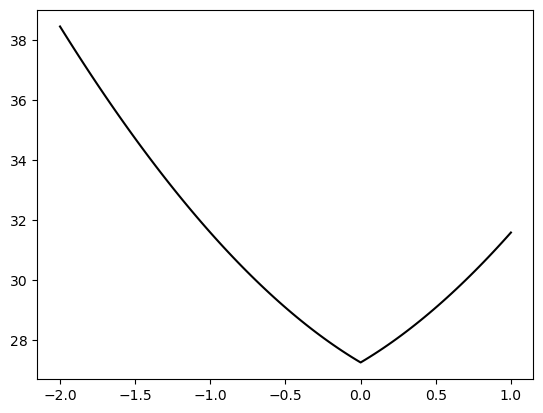

In [9]:
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
plt.plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')

# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [10]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [11]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=10,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [12]:
from bax_algorithms.emittance import PathwiseMinimizeEmittance
from bax_algorithms.pathwise.optimize import DifferentialEvolution

#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'energy': energy,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
        'use_bmag': use_bmag,
        'observable_names_ordered': ['xrms_sq','yrms_sq'],
        'optimizer': DifferentialEvolution(minimize=True, maxiter=10, verbose=True),
        # 'maxiter_fit': 10,
}
algo = PathwiseMinimizeEmittance(**algo_kwargs)
# algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         # gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

generator.gp_constructor.use_low_noise_prior = True
#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [13]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
X.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,2.820743,72.787116,633.460510,0.000508,False
1,-1.124443,0.259001,81.061884,224.509325,0.000378,False
2,0.127286,-0.894864,82.956814,58.561415,0.000501,False
3,-0.532483,1.329076,50.945344,270.147451,0.000295,False
4,-1.678841,-1.057529,262.872091,81.911586,0.000628,False
5,-1.688879,-0.545177,185.931997,147.518189,0.000410,False
6,0.623244,2.856109,73.093442,622.219047,0.000470,False
7,0.378271,-0.353125,79.236712,84.702181,0.000413,False
8,0.845598,1.444485,51.105035,394.691586,0.000441,False
9,-0.322430,0.509393,57.732465,136.235879,0.000377,False


In [14]:
reference_point = {var: 0.0 for var in vocs.variable_names}
reference_point

{'x0': 0.0, 'x1': 0.0}

Beginning BAX virtual optimization.
BAX virtual optimization took: 3.371829032897949 seconds.
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.207302808761597 seconds.


(<Figure size 600x400 with 2 Axes>,
 array([[<Axes: ylabel='xrms_sq'>],
        [<Axes: xlabel='x1', ylabel='yrms_sq'>]], dtype=object))

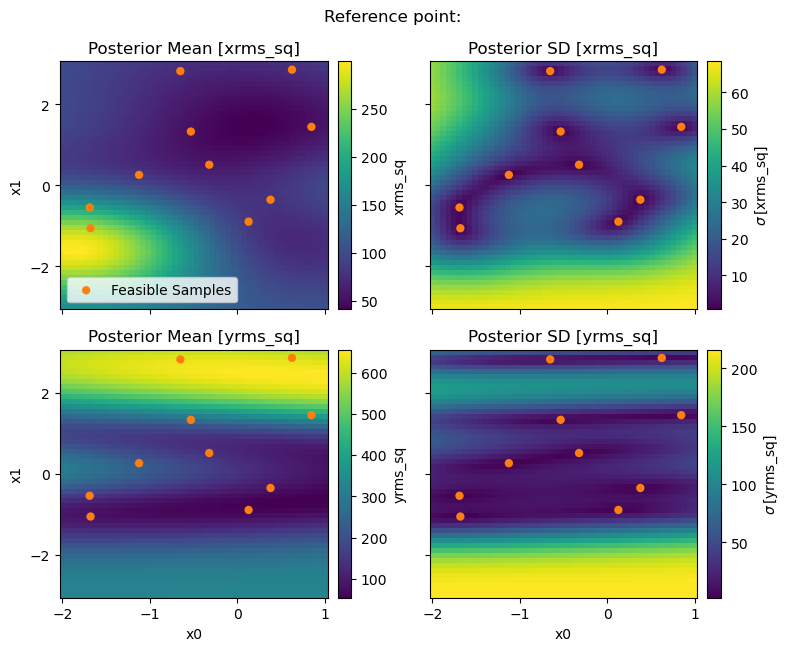

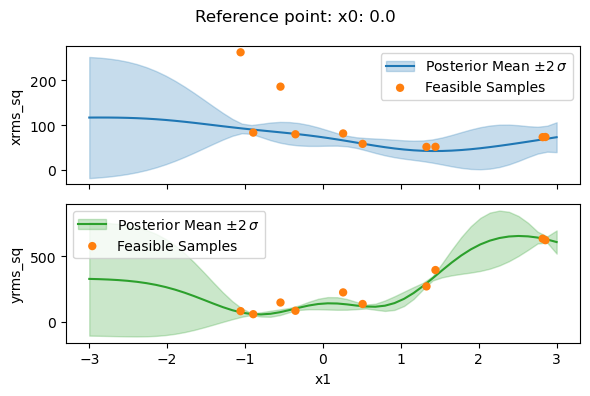

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
visualize_generator_model(X.generator, 
                          variable_names=['x0','x1'], 
                            reference_point=reference_point,
                          show_acquisition=False)
visualize_generator_model(X.generator, 
                          variable_names=['x1'], 
                            reference_point=reference_point,
                          show_acquisition=False)

In [16]:
X.generator.algorithm.results['best_inputs']

tensor([[[-1.8622]],

        [[-0.0550]],

        [[-0.0572]]])

2.987562656402588


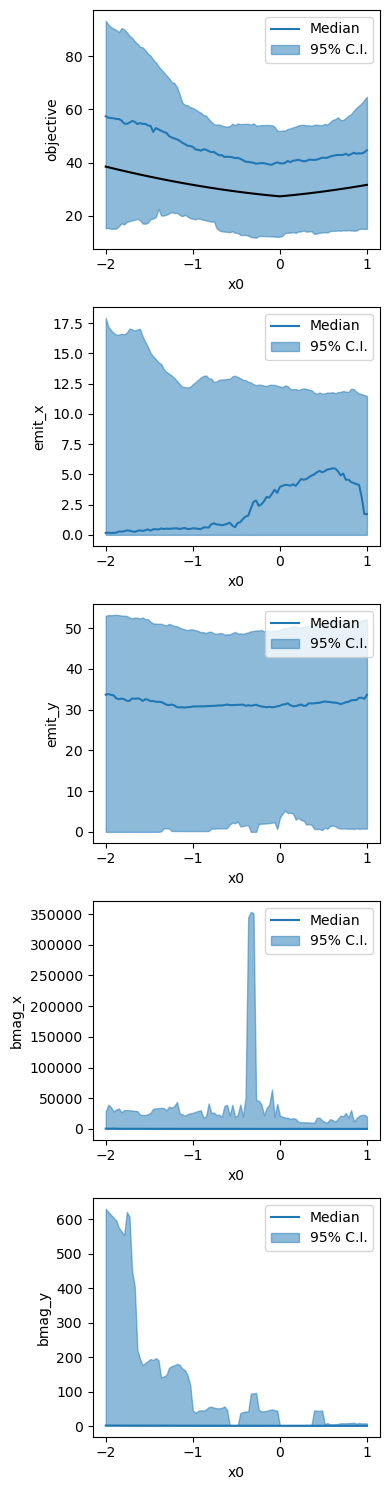

In [17]:
from bax_algorithms.visualize import visualize_virtual_measurement_result

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0'],
                            reference_point=reference_point,
                            n_grid=100,
                            n_samples=100,
                            result_keys=['objective','emit_x','emit_y','bmag_x','bmag_y'],
                            # show_samples=True,
                                     )
print(time.time()-start)
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
ax[0].plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')
# plt.ylim(top=0.01)

In [18]:
from bax_algorithms.utils import get_bax_mean_prediction, tuning_input_tensor_to_dict
mean_optimizer = DifferentialEvolution(minimize=True, popsize=100, maxiter=100, verbose=True)
x_tuning = get_bax_mean_prediction(X.generator, mean_optimizer)
x_tuning_dict = tuning_input_tensor_to_dict(X.generator, x_tuning)
print(x_tuning)
print(x_tuning_dict)

Beginning BAX virtual optimization.
BAX virtual optimization took: 7.3227009773254395 seconds.
tensor([[0.5005]])
{'x0': 0.5004669502593355}


In [19]:
for i in range(n_iter):
    print(i)
    start = time.time()
    X.step()
    print(time.time() - start)

0
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.397062063217163 seconds.
7.109896421432495
1
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.196184873580933 seconds.
7.584932804107666
2
Beginning BAX virtual optimization.
BAX virtual optimization took: 3.5121939182281494 seconds.
6.372234344482422
3
Beginning BAX virtual optimization.
BAX virtual optimization took: 3.357252597808838 seconds.
5.757641315460205
4
Beginning BAX virtual optimization.
BAX virtual optimization took: 3.903930425643921 seconds.
6.6770243644714355
5
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.137221097946167 seconds.
6.492925643920898
6
Beginning BAX virtual optimization.
BAX virtual optimization took: 3.310230016708374 seconds.
5.964805603027344
7
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.241548776626587 seconds.
6.646843194961548
8
Beginning BAX virtual optimization.
BAX virtual optimization took: 4.075564861297607

In [20]:
start = time.time()
X.generator.train_model()
print(time.time()-start)

0.3644223213195801


2.5880584716796875


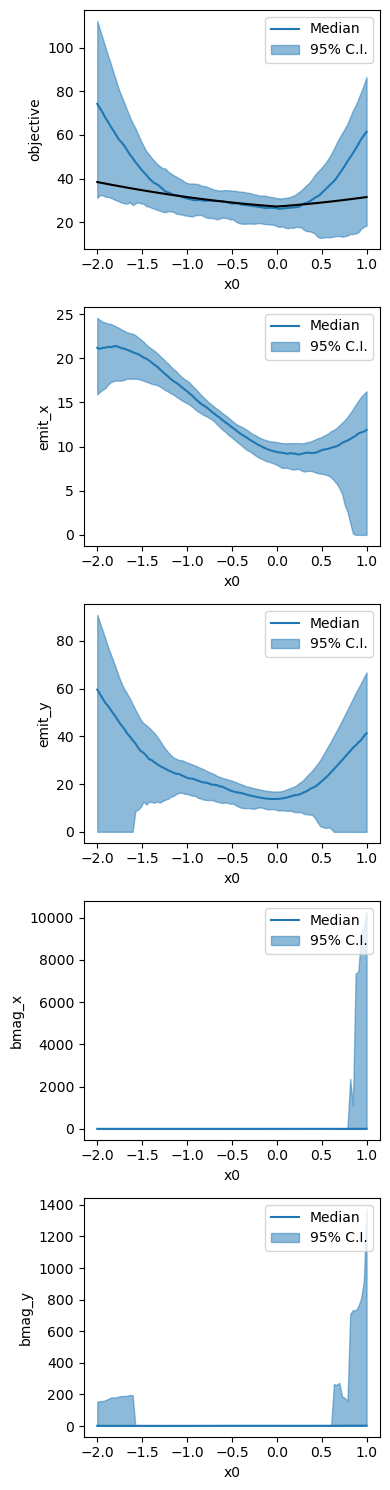

In [21]:
from bax_algorithms.visualize import visualize_virtual_measurement_result

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0'],
                            reference_point=reference_point,
                            n_grid=100,
                            n_samples=100,
                            result_keys=['objective','emit_x','emit_y','bmag_x','bmag_y'],
                            # show_samples=True,
                                     )
print(time.time()-start)
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
ax[0].plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')

6.747840642929077


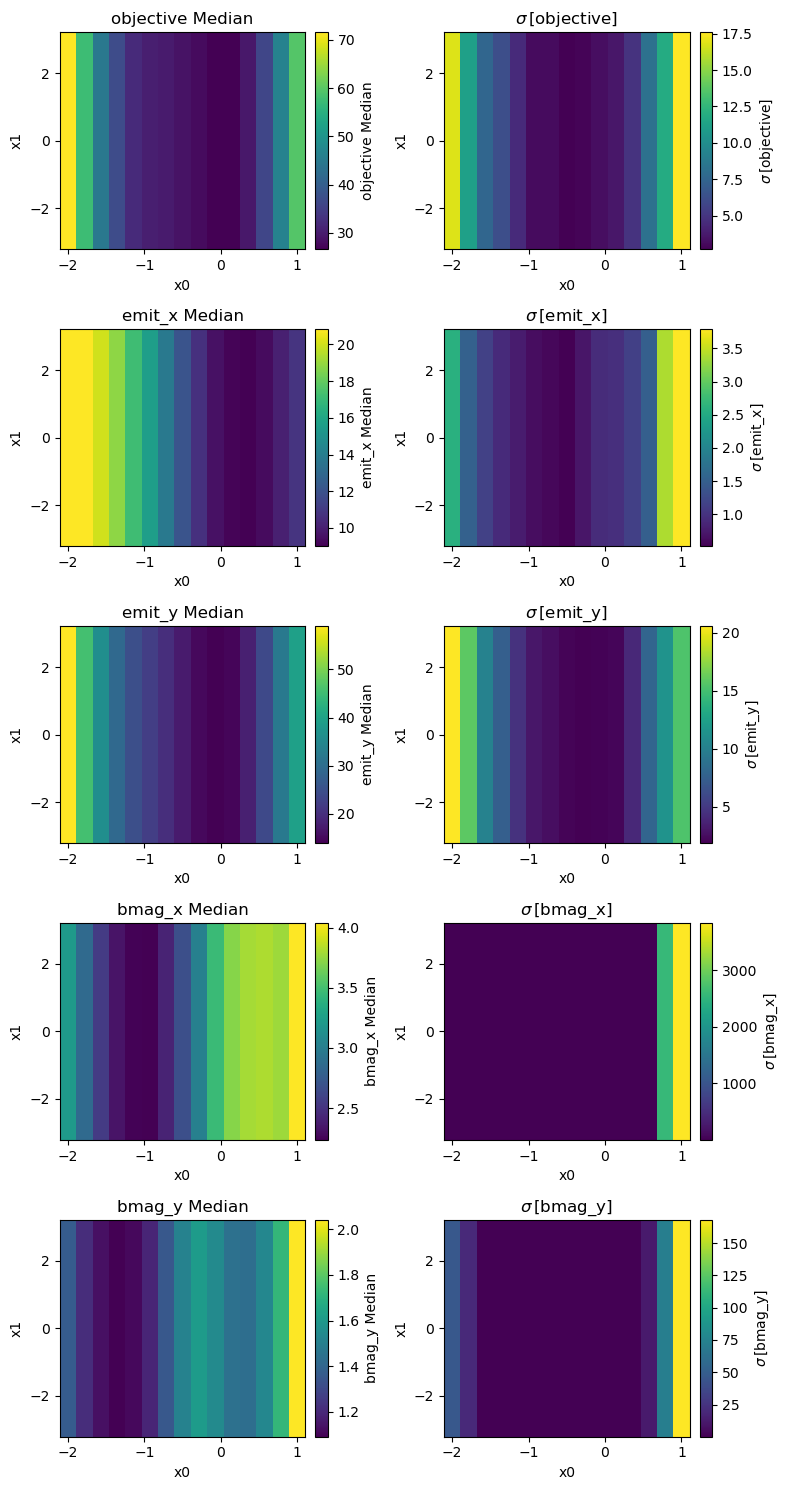

In [22]:
from bax_algorithms.visualize import visualize_virtual_measurement_result

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0','x1'],
                            reference_point=reference_point,
                            n_grid=15,
                            n_samples=100,
                            result_keys=['objective','emit_x','emit_y','bmag_x','bmag_y'],
                            # show_samples=True,
                                     )
print(time.time()-start)

In [23]:
x_tuning = get_bax_mean_prediction(X.generator, mean_optimizer)
x_tuning_dict = tuning_input_tensor_to_dict(X.generator, x_tuning)
print(x_tuning)
print(x_tuning_dict)

Beginning BAX virtual optimization.
BAX virtual optimization took: 0.4389309883117676 seconds.
tensor([[0.0234]])
{'x0': 0.02342076905151258}


In [24]:
from bax_algorithms.utils import uniform_random_sample_in_bounds
from bax_algorithms.utils import get_bax_model_and_bounds
bax_model, bounds = get_bax_model_and_bounds(X.generator)
x0 = uniform_random_sample_in_bounds(3000, bounds)
start = time.time()
algo.n_steps_measurement_param = 11
algo.evaluate_virtual_objective(X.generator.algorithm.results['sample_functions_list'], x0.reshape(n_samples, 1000, -1), bounds)
print(time.time()-start)

0.5974287986755371


In [25]:
fig, ax, best_q = plot_virtual_measurement_scan(X, reference_point, n_samples=10)
ax[0].set_ylim(top=1)
ax[1].set_ylim(top=3, bottom=0.9)
ax[0].axhline(0, c='k')

NameError: name 'plot_virtual_measurement_scan' is not defined

In [7]:
from unittest import TestCase
from unittest.mock import MagicMock, patch, Mock
from matplotlib import pyplot as plt
import numpy as np

from lcls_tools.common.devices.magnet import Magnet, MagnetMetadata
from lcls_tools.common.devices.reader import create_magnet
from lcls_tools.common.devices.screen import Screen
from lcls_tools.common.frontend.plotting.emittance import plot_quad_scan_result
from lcls_tools.common.measurements.emittance_measurement import QuadScanEmittance
from lcls_tools.common.measurements.screen_profile import (
    ScreenBeamProfileMeasurement,
    ScreenBeamProfileMeasurementResult,
)


class EmittanceMeasurementTest(TestCase):
    def setUp(self) -> None:
        self.options = [
            "TRIM",
            "PERTURB",
            "BCON_TO_BDES",
            "SAVE_BDES",
            "LOAD_BDES",
            "UNDO_BDES",
            "DAC_ZERO",
            "CALIB",
            "STDZ",
            "RESET",
            "TURN_OFF",
            "TURN_ON",
            "DEGAUSS",
        ]
        self.ctrl_options_patch = patch("epics.PV.get_ctrlvars", new_callable=Mock)
        self.mock_ctrl_options = self.ctrl_options_patch.start()
        self.mock_ctrl_options.return_value = {"enum_strs": tuple(self.options)}
        self.magnet_collection = create_magnet(area="GUNB")
        return super().setUp()

    def test_measure_with_mocked_beamsize_measurement(self):
        """
        Test to verify correct emittance calculation based on data generated from a
        basic cheetah simulation of a quad and drift element.

        The cheetah simulation data is generated by running the following script:
        >>> from cheetah import Segment, Quadrupole, Drift, ParameterBeam
        >>> initial_beam = ParameterBeam.from_twiss(
                beta_x=torch.tensor(5.0),
                alpha_x=torch.tensor(5.0),
                emittance_x=torch.tensor(1e-8),
                beta_y=torch.tensor(3.0),
                alpha_y=torch.tensor(3.0),
                emittance_y=torch.tensor(1e-7),
            )
        >>> beamline = Segment([
            Quadrupole(name=f"Q0", length=torch.tensor(0.1)),
            Drift(length=torch.tensor(1.0))
        ])
        >>> output_beam = beamline.track(initial_beam)

        """
        # define rmat and design twiss
        # design twiss set such that the 5th element of the quad scan is the design
        # setting
        rmat = np.array([[[1, 1.0], [0, 1]], [[1, 1.0], [0, 1]]])
        design_twiss = {
            "beta_x": 0.2452,
            "alpha_x": -0.1726,
            "beta_y": 0.5323,
            "alpha_y": -1.0615,
        }
        # Prepare mock data (generated by cheetah simulation)
        k = np.linspace(-10, 10, 10)
        x_data = (
            np.array(
                [
                    2.11004182e-04,
                    1.61777833e-04,
                    1.14536742e-04,
                    7.24512720e-05,
                    4.95130807e-05,
                    6.79336517e-05,
                    np.nan,
                    1.52933266e-04,
                    1.99458518e-04,
                    2.46393640e-04,
                ]
            )
            * 1e6
        )
        y_data = (
            np.array(
                [
                    6.22674183e-04,
                    np.nan,
                    np.nan,
                    3.07886046e-04,
                    2.30726553e-04,
                    2.01972667e-04,
                    2.41091911e-04,
                    3.25417204e-04,
                    4.29859007e-04,
                    5.43555594e-04,
                ]
            )
            * 1e6
        )

        # run test with and without design_twiss
        for design_twiss_ele in [None, design_twiss]:
            for n_shots in [1, 3]:
                mock_beamsize_measurements = []
                for i, val in enumerate(k):
                    result = MagicMock(ScreenBeamProfileMeasurementResult)
                    result.rms_sizes = np.array(
                        [float(x_data[i]), float(y_data[i])]
                    ).reshape(1, 2)

                    # extend result.rms_sizes to simulate multiple shots
                    result.rms_sizes = np.repeat(result.rms_sizes, n_shots, axis=0)
                    mock_beamsize_measurements += [result]

                # External list to return beam sizes
                external_list = iter(mock_beamsize_measurements)

                # Mock beamsize_measurement
                mock_beamsize_measurement = MagicMock(spec=ScreenBeamProfileMeasurement)
                mock_beamsize_measurement.device = MagicMock(spec=Screen)
                mock_beamsize_measurement.device.resolution = 1.0
                mock_beamsize_measurement.measure = MagicMock(
                    side_effect=lambda _: next(external_list)
                )

                # Mock magnet
                mock_magnet = MagicMock(spec=Magnet)
                mock_magnet.metadata = MagnetMetadata(
                    area="test", beam_path=["test"], sum_l_meters=None, l_eff=0.1
                )

                def mock_function(scan_settings, function):
                    for ele in scan_settings:
                        function()

                mock_magnet.scan = mock_function

                # Instantiate the QuadScanEmittance object
                quad_scan = QuadScanEmittance(
                    energy=1e9 * 299.792458 / 1e3,
                    scan_values=k,
                    magnet=mock_magnet,
                    beamsize_measurement=mock_beamsize_measurement,
                    n_measurement_shots=1,
                    rmat=rmat,
                    design_twiss=design_twiss_ele,
                    wait_time=1e-3,
                )

                # Call the measure method
                result = quad_scan.measure()

                # check outputs based on nans in the data
                assert np.equal(
                    result.quadrupole_pv_values[0], np.concatenate((k[:6], k[7:]))
                ).all()
                assert np.equal(
                    result.quadrupole_pv_values[1], np.concatenate((k[:1], k[3:]))
                ).all()

                assert np.allclose(
                    result.rms_beamsizes[0] * 1e6, x_data[~np.isnan(x_data)]
                )
                assert np.allclose(
                    result.rms_beamsizes[1] * 1e6, y_data[~np.isnan(y_data)]
                )

                # check resulting calculations against cheetah simulation ground truth
                assert np.allclose(
                    result.emittance,
                    np.array([1.0e-2, 1.0e-1]).reshape(2, 1),
                )
                assert np.allclose(
                    result.beam_matrix,
                    np.array([[5.0e-2, -5.0e-2, 5.2e-2], [0.3, -0.3, 0.33333328]]),
                )

                if design_twiss_ele is None:
                    assert result.bmag is None
                else:
                    assert np.allclose(result.bmag[0][4], 1.0)

                    # test get_best_bmag method
                    for mode in ["x", "y", "geometric_mean", "joint_max"]:
                        best_bmag = result.get_best_bmag(mode)
                        if mode == "x":
                            assert np.allclose(best_bmag[0], 1.0, rtol=1e-2)
                            assert np.allclose(best_bmag[1], k[4], rtol=1e-2)
                        elif mode == "y":
                            assert np.allclose(best_bmag[0], 1.0, rtol=1e-2)
                            assert np.allclose(best_bmag[1], k[4], rtol=1e-2)
                        elif mode == "geometric_mean":
                            assert np.allclose(best_bmag[0], 1.0, rtol=1e-2)
                            assert np.allclose(best_bmag[1], k[4], rtol=1e-2)
                        elif mode == "joint_max":
                            assert np.allclose(best_bmag[0], 1.0, rtol=1e-2)
                            assert np.allclose(best_bmag[1], -0.909, rtol=1e-2)

                # test visualization
                fig, ax = plot_quad_scan_result(result)
                assert isinstance(fig, plt.Figure)
                assert isinstance(ax, np.ndarray)


In [8]:
test = EmittanceMeasurementTest()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bmag =  [ 9.27751028  8.9108695   8.55254307  8.202531    7.86083328  7.52744991
  7.2023809   6.88562624  6.57718594  6.27705999  5.9852484   5.70175116
  5.42656828  5.15969975  4.90114557  4.65090575  4.40898028  4.17536917
  3.95007241  3.73309001  3.52442196  3.32406827  3.13202893  2.94830394
  2.77289331  2.60579703  2.44701511  2.29654754  2.15439433  2.02055547
  1.89503096  1.77782081  1.66892502  1.56834358  1.47607649  1.39212376
  1.31648538  1.24916136  1.19015169  1.13945637  1.09707541  1.06300881
  1.03725655  1.01981866  1.01069511  1.00988593  1.01739109  1.03321061
  1.05734449  1.08979272  1.1305553   1.17963224  1.23702353  1.30272918
  1.37674918  1.45908354  1.54973225  1.64869531  1.75597273  1.87156451
  1.99547064  2.12769112  2.26822596  2.41707515  2.57423869  2.73971659
  2.91350885  3.09561546  3.28603642  3.48477174  3.69182141  3.90718544
  4.13086382  4.36285656  4.60316365  4.85178509  5.10872089  5.37397105
  5.64753556  5.92941442  6.21960764  6.518

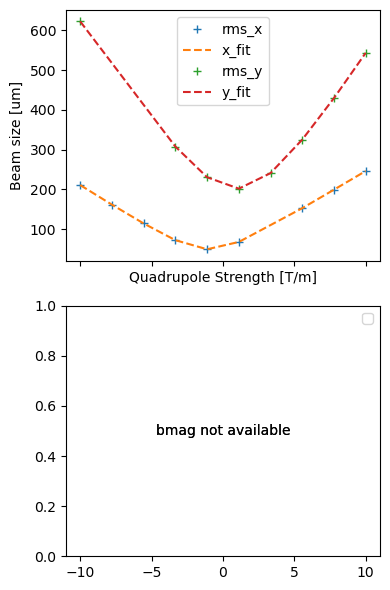

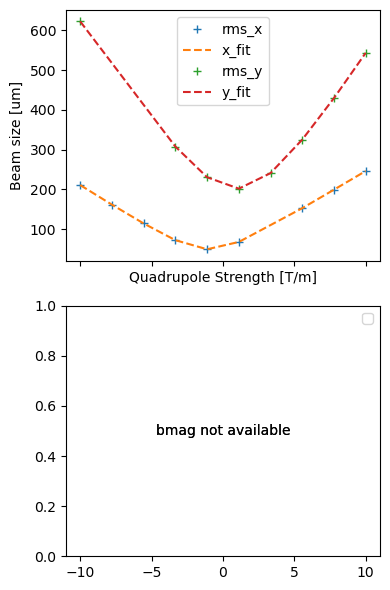

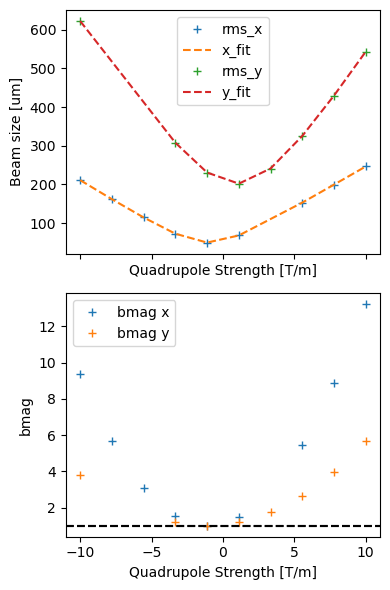

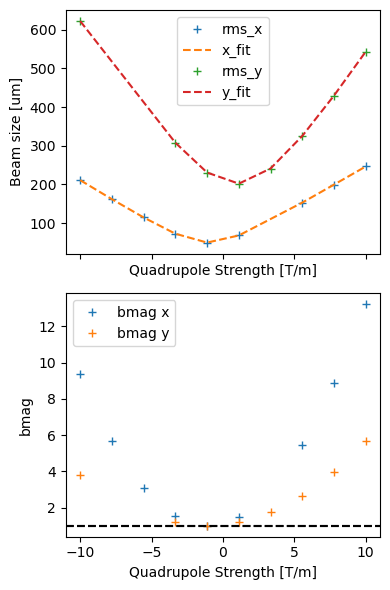

In [9]:
test.test_measure_with_mocked_beamsize_measurement()